# 1) 데이터 준비와 확인 

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2) 데이터 로더 구성
실습때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거   
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

3) 모델구성을 위한 데이터 분석 및 가공   
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

4) 모델구성 및 validation set 구성
- 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

5) 모델 훈련 개시   
6) Loss, Accuracy 그래프 시각화   
7) 학습된 Embedding 레이어 분석   
8) 한국어 Word2Vec 임베딩 활용하여 성능개선      
한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.   
[링크](https://github.com/Kyubyong/wordvectors) 

# 3) 모델구성을 위한 데이터 분석 및 가공   
- 데이터셋 내 문장 길이 분포   
- 적절한 최대 문장 길이 지정   
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [5]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0]) # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 됩니다. 그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적입니다. 따라서 'pre'가 훨씬 유리하며, 10% 이상의 테스트 성능 차이를 보이게 됩니다.

In [7]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


# 4) 모델구성 및 validation set 구성
- 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

1. 모델 1    
1537/1537 - 2s - loss: 0.4080 - accuracy: 0.8438


In [33]:
# vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
# word_vector_dim = 64  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)


# # model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
# model = keras.Sequential()
# # [[YOUR CODE]]
# model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model.add(keras.layers.Conv1D(16, 7, activation='relu'))
# model.add(keras.layers.MaxPooling1D(5))
# model.add(keras.layers.Conv1D(16, 7, activation='relu'))
# model.add(keras.layers.GlobalMaxPooling1D())
# model.add(keras.layers.Dense(8, activation='relu'))
# model.add(keras.layers.Dense(1, activation='sigmoid')) 
# model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          7184      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

2. 모델2(LSTM)  

1537/1537 - 2s - loss: 0.3711 - accuracy: 0.8510

In [30]:
# vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
# word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model = keras.Sequential()
# model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model.add(keras.layers.LSTM(100))  
# model.add(keras.layers.Dense(16, activation='relu'))
# model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


# model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               120400    
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 2,122,033
Trainable params: 2,122,033
Non-trainable params: 0
_________________________________________________________________


3. 모델3(GRU)   
1537/1537 - 3s - loss: 0.3509 - accuracy: 0.8521


In [36]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 128  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GRU(128, return_sequences=True))  
model.add(keras.layers.GRU(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 1,478,273
Trainable params: 1,478,273
Non-trainable params: 0
_________________________________________________________________


In [37]:
# validation set 30000건 분리
x_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 약 100000건
partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116182, 41)
(116182,)


# 5) 모델 훈련 개시


In [38]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
227/227 [==============================] - 6s 26ms/step - loss: 0.4104 - accuracy: 0.8102 - val_loss: 0.3440 - val_accuracy: 0.8500
Epoch 2/5
227/227 [==============================] - 5s 21ms/step - loss: 0.3163 - accuracy: 0.8648 - val_loss: 0.3289 - val_accuracy: 0.8576
Epoch 3/5
227/227 [==============================] - 5s 22ms/step - loss: 0.2770 - accuracy: 0.8851 - val_loss: 0.3234 - val_accuracy: 0.8612
Epoch 4/5
227/227 [==============================] - 5s 21ms/step - loss: 0.2448 - accuracy: 0.9003 - val_loss: 0.3322 - val_accuracy: 0.8591
Epoch 5/5
227/227 [==============================] - 5s 21ms/step - loss: 0.2185 - accuracy: 0.9128 - val_loss: 0.3411 - val_accuracy: 0.8578


In [39]:
#모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3509 - accuracy: 0.8521
[0.3508870005607605, 0.852106511592865]


# 6) Loss, Accuracy 그래프 시각화

In [14]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


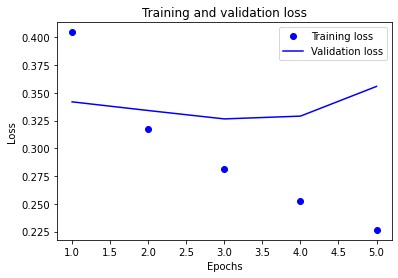

In [15]:

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- 그래프 상으로 epoch = 2 가 적절한 트레이닝 횟수다.

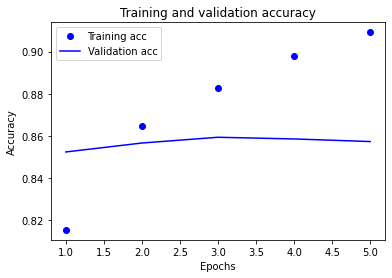

In [16]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 정확도에 대해 그려보아도 epoch = 2 로 유사한 인사이트를 얻었다.

# 7) 학습된 Embedding 레이어 분석   
- 워드벡터를 다루는데 유용한 gensim패키지 설치   

$ pip install gensim

In [17]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 128)


In [18]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [19]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.00263833,  0.00033974, -0.03834974,  0.00702859,  0.02060126,
        0.18917789, -0.02587415, -0.01684641, -0.05923314, -0.01432207,
        0.0087879 ,  0.03821717,  0.00638302, -0.01804191, -0.0380526 ,
       -0.01284638, -0.13259655,  0.02858651,  0.01605869,  0.0208548 ,
       -0.00943789, -0.00021626, -0.04723758, -0.0191913 ,  0.00092809,
        0.04810488, -0.02040966,  0.06388142,  0.05377464,  0.03515829,
       -0.03041363, -0.00423198, -0.020919  ,  0.01761923,  0.01445809,
        0.07387696,  0.02275708,  0.0128571 , -0.0535947 , -0.00620267,
        0.00253674, -0.02361424, -0.00608772, -0.00343824,  0.00602173,
        0.03295819,  0.04142662,  0.00020969,  0.02659093,  0.03018823,
        0.05475846,  0.03474034, -0.01952055, -0.07025839, -0.02565456,
        0.00855627,  0.00935868,  0.07222675, -0.06150422, -0.04187658,
        0.04279607,  0.02128967, -0.01667389,  0.01004132, -0.02661511,
       -0.04673911, -0.0497111 ,  0.00970214,  0.03410593, -0.05

In [20]:
word_vectors.similar_by_word("재미")

[('이뻐서', 0.6484808325767517),
 ('공감', 0.6367604732513428),
 ('굳', 0.6311620473861694),
 ('만점', 0.6266863942146301),
 ('~~^^', 0.6233808398246765),
 ('매력', 0.6140471696853638),
 ('당연히', 0.6114957928657532),
 ('~!!!', 0.6056923270225525),
 ('귀여움', 0.6053521633148193),
 ('되게', 0.6050054430961609)]

- 큰 연관성을 찾기는 힘들어 보인다.

# 8) 한국어 Word2Vec 임베딩 활용하여 성능개선
한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.   
[링크](https://github.com/Kyubyong/wordvectors)   

In [42]:
from gensim.models import KeyedVectors
import gensim
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
# word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['재미']
vector     # 무려 300dim의 워드 벡터입니다.

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-0.01228145, -0.4937083 ,  0.4424771 , -1.0789338 , -1.0551587 ,
       -0.8106456 , -0.0881472 ,  0.7738013 , -0.3837249 , -0.31405708,
        0.18792619, -0.04978764,  0.3977235 ,  1.0052139 , -0.5921918 ,
        0.57315415, -0.13287784,  1.4190367 ,  0.5338879 ,  0.08187074,
       -0.21017547, -0.31960285,  0.08991678, -0.06743078,  0.14399454,
        0.04861213,  0.4904712 ,  0.38203648, -0.33213428, -0.48618734,
       -0.6996383 , -0.48903087, -0.5666092 ,  0.11454912,  0.7527777 ,
       -1.6491356 ,  0.709264  ,  0.14231981,  1.2408166 ,  0.9104645 ,
        1.0235597 , -0.7135743 , -0.5323588 , -0.16439462, -0.12318534,
       -0.41341293,  0.76286334, -0.24337888, -1.0924134 , -0.78981435,
        0.24504295, -0.472915  , -0.17546178,  0.10006592, -1.2155428 ,
        0.4059387 ,  0.8259838 , -0.18593056, -0.21122731, -0.46615708,
        0.74433243, -0.18605745, -0.9175297 ,  0.08531424,  0.09134697,
       -0.60375917,  0.5236646 ,  0.7689134 ,  0.19123535,  0.60

In [43]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("재미")

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  


[('취미', 0.5857348442077637),
 ('유머', 0.514061450958252),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338053226471),
 ('공짜', 0.4960595965385437),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700761795043945),
 ('비애', 0.4836210608482361),
 ('관객', 0.4828645586967468),
 ('향수', 0.48233112692832947)]

- '재미'와의 유사성이 엄청 올라갔다.

In [44]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [45]:
import keras
from keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [47]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
227/227 [==============================] - 4s 19ms/step - loss: 0.2448 - accuracy: 0.9022 - val_loss: 0.3553 - val_accuracy: 0.8468
Epoch 2/5
227/227 [==============================] - 4s 19ms/step - loss: 0.2246 - accuracy: 0.9124 - val_loss: 0.3840 - val_accuracy: 0.8455
Epoch 3/5
227/227 [==============================] - 4s 19ms/step - loss: 0.2063 - accuracy: 0.9204 - val_loss: 0.3912 - val_accuracy: 0.8455
Epoch 4/5
227/227 [==============================] - 4s 19ms/step - loss: 0.1876 - accuracy: 0.9296 - val_loss: 0.4043 - val_accuracy: 0.8458
Epoch 5/5
227/227 [==============================] - 4s 19ms/step - loss: 0.1712 - accuracy: 0.9368 - val_loss: 0.4329 - val_accuracy: 0.8413


In [49]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4451 - accuracy: 0.8362
[0.44505590200424194, 0.8362186551094055]


In [50]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


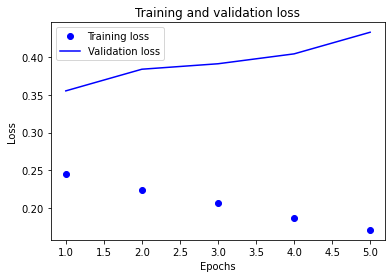

In [51]:

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

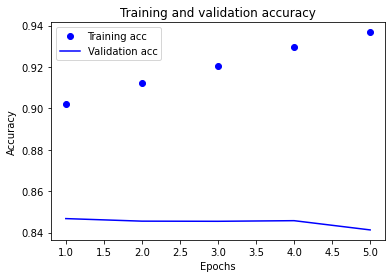

In [52]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 총평   
- GRU모델의 결과값이 제일 좋았다.   
- Word2Vec을 썻을 때 약 5%의 상승치를 보일 줄 알았는데 결과는 똑같았다.   